# Data Treatment
[CSV Link](https://www.kaggle.com/datasets/prosperchuks/health-dataset?resource=download&select=stroke_data.csv)

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import pickle as pk
import sklearn as sk
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (roc_curve, auc, precision_recall_curve, 
                            average_precision_score, f1_score, classification_report)
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

In [5]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
warnings.filterwarnings('ignore')

In [6]:
df = pd.read_csv('../data/stroke_data.csv', encoding='unicode_escape')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40910 entries, 0 to 40909
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sex                40907 non-null  float64
 1   age                40910 non-null  float64
 2   hypertension       40910 non-null  int64  
 3   heart_disease      40910 non-null  int64  
 4   ever_married       40910 non-null  int64  
 5   work_type          40910 non-null  int64  
 6   Residence_type     40910 non-null  int64  
 7   avg_glucose_level  40910 non-null  float64
 8   bmi                40910 non-null  float64
 9   smoking_status     40910 non-null  int64  
 10  stroke             40910 non-null  int64  
dtypes: float64(4), int64(7)
memory usage: 3.4 MB


In [8]:
df.stroke.value_counts()

stroke
1    20460
0    20450
Name: count, dtype: int64

In [9]:
df.sex.replace({'Male':0, 'Female':1, 'Other':0}, inplace=True)
df.sex.fillna(0, inplace=True)
df.ever_married.replace({'No':0, 'Yes':1}, inplace=True)
df.Residence_type.replace({'Rural':0, 'Urban':1}, inplace=True)
df.smoking_status.replace({'Unknown':0, 'never smoked':1, 'formerly smoked':2, 'smokes':3}, inplace=True)
df.work_type.replace({'Never_worked':0, 'children':1, 'Govt_job':2, 'Private':3, 'Self-employed':4}, inplace=True)
df.bmi.fillna(df.bmi.mean(), inplace=True)

# Training Model

In [10]:
x = df.drop(['stroke', 'ever_married', 'sex', 'smoking_status', 'Residence_type'], axis='columns')
y = df[['stroke']]

# Dividindo dados para treino e dados para teste
x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    test_size = 0.3, 
                                                    random_state = 1)

In [11]:
scaler = MinMaxScaler()

x_train[['age', 'avg_glucose_level', 'bmi']] = scaler.fit_transform(x_train[['age','avg_glucose_level', 'bmi']])

x_test[['age', 'avg_glucose_level', 'bmi']] = scaler.transform(x_test[['age','avg_glucose_level', 'bmi']])

In [12]:
gbc = GradientBoostingClassifier(n_estimators=200, learning_rate=1.0, max_depth=1, random_state=0)
gbc.fit(x_train, y_train.squeeze())

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, n_estimators=200,
                           random_state=0)

In [13]:
print(classification_report(y_test, gbc.predict(x_test)))

              precision    recall  f1-score   support

           0       0.74      0.80      0.77      6105
           1       0.78      0.73      0.75      6168

    accuracy                           0.76     12273
   macro avg       0.76      0.76      0.76     12273
weighted avg       0.76      0.76      0.76     12273



# Viewing results of model training

In [14]:
y_score = gbc.predict_proba(x_test)[:, 1] # probabilidade de ser 1

fpr_gbc, tpr_gbc, _ = roc_curve(y_test, y_score)
roc_auc_gbc = auc(fpr_gbc, tpr_gbc)

precision_gbc, recall_gbc, _ = precision_recall_curve(y_test, y_score)
average_precision_gbc = average_precision_score(y_test, y_score)

In [15]:
f1_gbc = f1_score(y_test, gbc.predict(x_test))

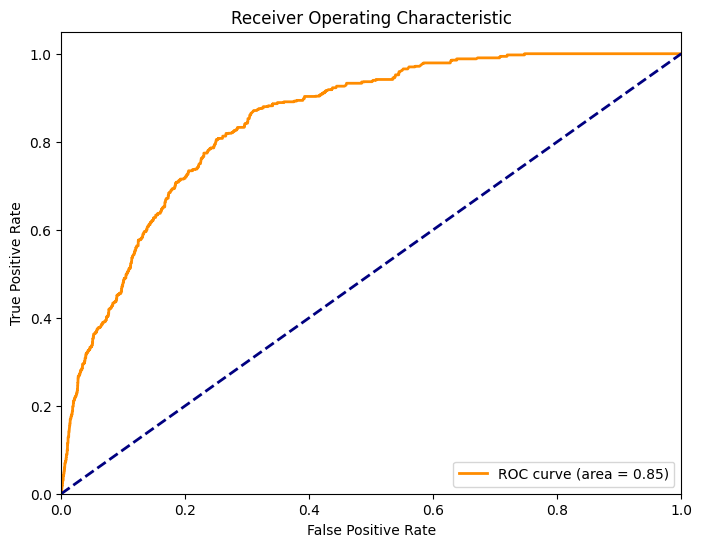

In [16]:
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_gbc, tpr_gbc, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc_gbc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

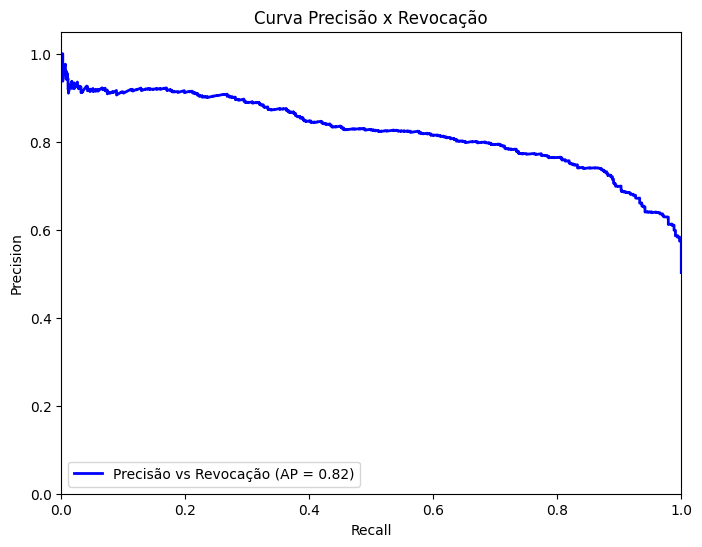

In [17]:
# Plot curva de precisão-revocação
plt.figure(figsize=(8, 6))
plt.plot(recall_gbc, precision_gbc, color='blue', lw=2, label='Precisão vs Revocação (AP = {:.2f})'.format(average_precision_gbc))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precisão x Revocação')
plt.legend(loc="lower left")
plt.show()

In [18]:
print('F1 Score: {:.4f}'.format(f1_gbc))

F1 Score: 0.7536


Feature Importances:
avg_glucose_level: 0.47904019108302237
bmi: 0.20911528792329076
hypertension: 0.11900991125776159
age: 0.07817612866921461
heart_disease: 0.06959221576038643
work_type: 0.045066265306324176


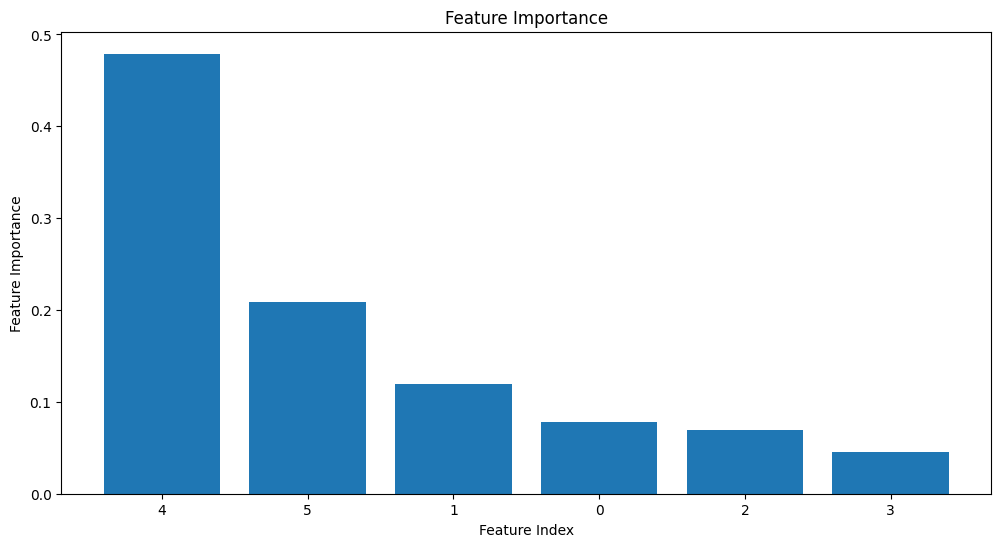

In [19]:
feature_importances = gbc.feature_importances_

indices = np.argsort(feature_importances)[::-1]

# Print and plot feature importances
print("Feature Importances:")
for f in range(x_train.shape[1]):
    print(f"{x_train.columns[indices[f]]}: {feature_importances[indices[f]]}")

plt.figure(figsize=(12, 6))
plt.title("Feature Importance")
plt.bar(range(x_train.shape[1]), feature_importances[indices], align="center")
plt.xticks(range(x_train.shape[1]), indices)
plt.xlabel("Feature Index")
plt.ylabel("Feature Importance")
plt.show()

# Exporting model 

In [34]:
print(x_test.columns[indices[:7]])

Index(['avg_glucose_level', 'bmi', 'hypertension', 'age', 'heart_disease',
       'work_type'],
      dtype='object')


In [20]:
pk.dump(gbc, open("model.pkl", "wb"))

In [101]:
model_mtd2 = pk.load(open("model.pkl", "rb"))

result = model_mtd2.predict_proba([[20, 0, 1, 0, 11, 100]])
print("The result is", result[0])

len(result[0])

The result is [0.24735978 0.75264022]


2

In [72]:
import joblib

# Load the pickled model
loaded_model = joblib.load('model.pkl')

feature_names = loaded_model.get_params()['input_features']
print("Feature Names:", feature_names)

KeyError: 'input_features'